In [90]:
%%html
<script>
    // document.getElementById("kk").innerHTML = document.documentElement.innerHTML.replaceAll('<', '*').replaceAll('>', '+');
</script>

<div id="kk">
asd
</div>

<style>
app-text-output > div:first-child {
    transform: scale(1.5);
}
    
div.output_subarea > div:first-child {
    transform: scale(1.5);
}

div > div {
    transform: scale(1);
}
</style>

# Start from here

In [2]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame, Series
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

from datatools import extract_market_data, data_quantization
from pipeline import Dataset
from pipeline.backtest import evaluation_for_submission, cross_validation
from visualization.metric import plot_performance

import xarray as xr
import seaborn as sns
sns.set_theme(style="whitegrid")

In [4]:
from qids_lib import QIDS

qids = QIDS(path_prefix='../../')

In [74]:
base_ds = xr.open_dataset('../../data/nc/base.nc')
market_brief_ds = xr.open_dataset('../../data/nc/market_brief.nc')
ds_bak = base_ds.merge(market_brief_ds)

## Some basic information about the dataset

In [6]:
ds

<xarray.Dataset>
Dimensions:            (day: 1000, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/22)
    open               (day, asset, timeslot) float64 ...
    close              (day, asset, timeslot) float64 ...
    high               (day, asset, timeslot) float64 ...
    low                (day, asset, timeslot) float64 ...
    volume             (day, asset, timeslot) float64 ...
    money              (day, asset, timeslot) float64 ...
    ...                 ...
    mean_volume        (day, asset) float64 ...
    close_0            (day, asset) float64 ...
    open_0             (day, asset) float64 ...
    high_0             (day, asset) float64 ...
    low_0              (day, asset) float64 ...
    return_0           (day, asset) float64 ...

## Turnover

<Axes: xlabel='asset', ylabel='turnoverRatio'>

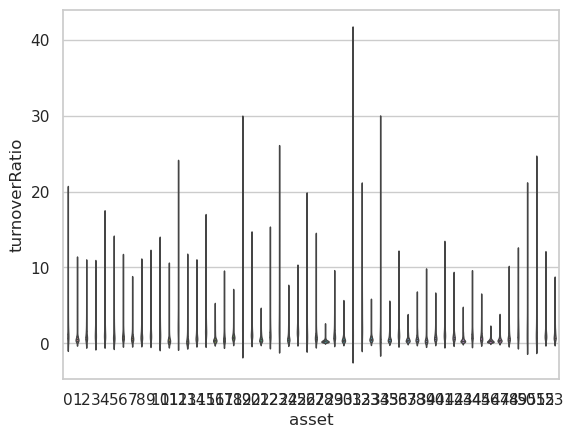

In [7]:
feature = 'turnoverRatio'
sns.violinplot(data=ds[feature].to_dataframe().reset_index(), x='asset', y=feature, inner='quart', linewidth=1)

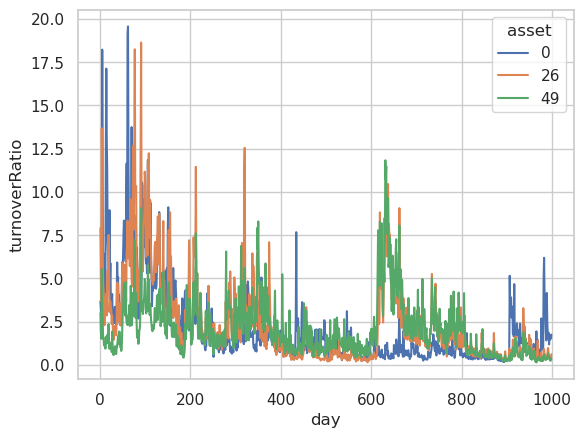

In [8]:
feature = 'turnoverRatio'
ds[feature].sel(asset=[0,26,49]).plot.line(x='day')

**For Turnover**

So apparently, the first 200 days display a quite different characteristic than the remaining days; the last 50 days is also worth noticing.

Also, the 26 and 49 asset has very similar turnoverRatios

<Axes: xlabel='turnoverRatio', ylabel='return_0'>

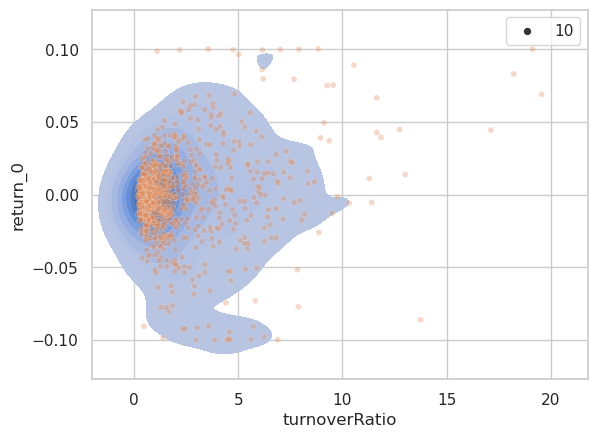

In [9]:
df = ds[['turnoverRatio', 'return_0']].sel(asset=0).to_dataframe()
plt.figure()
sns.kdeplot(data=df, x=feature, y='return_0', ax=plt.gca(), fill=True)
sns.scatterplot(data=df, x=feature, y='return_0', ax=plt.gca(), alpha=0.3, size=10)

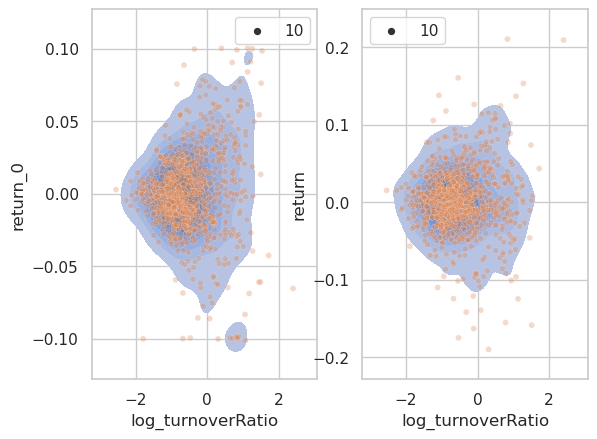

In [10]:
df = ds[['turnoverRatio', 'return_0', 'return']].sel(asset=1).to_dataframe()
df[f'log_{feature}'] = np.log(df[feature])
fig, axs = plt.subplots(nrows=1, ncols=2)
# return_label = 'return_0'
return_label = 'return'
for ax, return_label in zip(axs, ['return_0', 'return']):
    sns.kdeplot(data=df, x=f'log_{feature}', y=return_label, ax=ax, fill=True)
    sns.scatterplot(data=df, x=f'log_{feature}', y=return_label, ax=ax, alpha=0.3, size=10)

Question: Does the turnoverRatio correlate across different assets?

In [11]:
corr = ds.sel(day=slice(200,998))['turnoverRatio'].to_dataframe().reset_index().pivot(index='day', columns='asset', values='turnoverRatio').corr()
corr.index.rename('asset_0', inplace=True)
corr_long = corr.stack().rename('correlation')

/tmp/ipykernel_52059/4289007858.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for artist in g.legend.legendHandles:


Text(0.5, 1.0, 'Correlation plot for turnoverRatio')

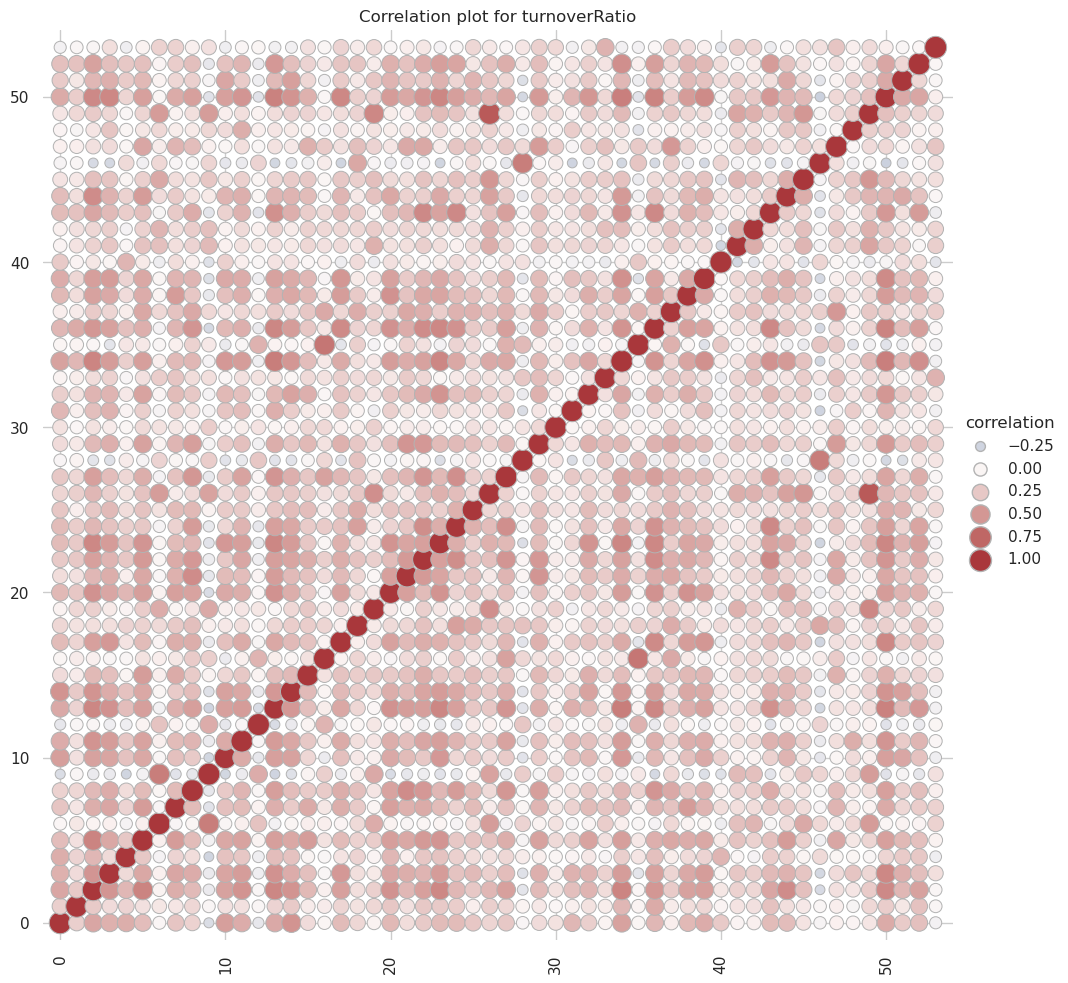

In [12]:
g = sns.relplot(
    data=corr_long.reset_index(),
    x='asset', y='asset_0', hue='correlation', size='correlation',
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
plt.title(f'Correlation plot for {feature}')

## TransactionAmount

<Axes: xlabel='asset', ylabel='transactionAmount'>

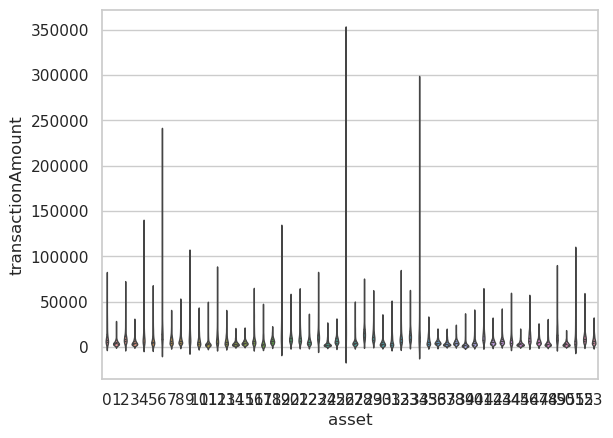

In [13]:
feature = 'transactionAmount'
sns.violinplot(data=ds[feature].to_dataframe().reset_index(), x='asset', y=feature, inner='quart', linewidth=1)

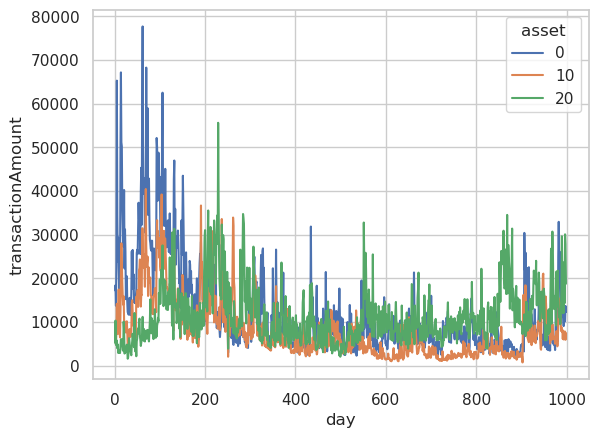

In [14]:
feature = 'transactionAmount'
ds[feature].sel(asset=[0,10,20]).plot.line(x='day')

Looks like TransactionAmount is very close to turnoverRatio, fishy

In [15]:
ratio = ds['transactionAmount'] / ds['turnoverRatio']

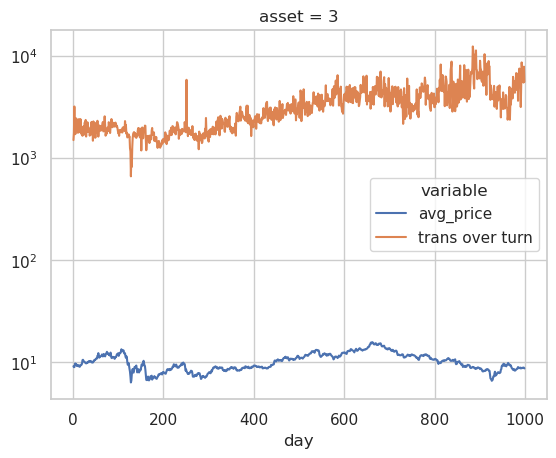

In [16]:
ds[['avg_price']].merge(ratio.rename('trans over turn')).sel(asset=3).to_array().plot.line(x='day')
plt.yscale('log')

Question: Does the transactionAmount correlate across different assets?

In [102]:
def plot_corr(ds, col):
    corr = ds[col].to_dataframe().reset_index().pivot(index='day', columns='asset', values=col).corr()
    corr.index.rename('asset_0', inplace=True)
    corr_long = corr.stack().rename('correlation')
    g = sns.relplot(
        data=corr_long.reset_index(),
        x='asset', y='asset_0', hue='correlation', size='correlation',
        palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
        height=10, sizes=(50, 250), size_norm=(-.2, .8),
    )

    # Tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")
    plt.title(f'Correlation for {col}')

/tmp/ipykernel_149554/2636301194.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for artist in g.legend.legendHandles:


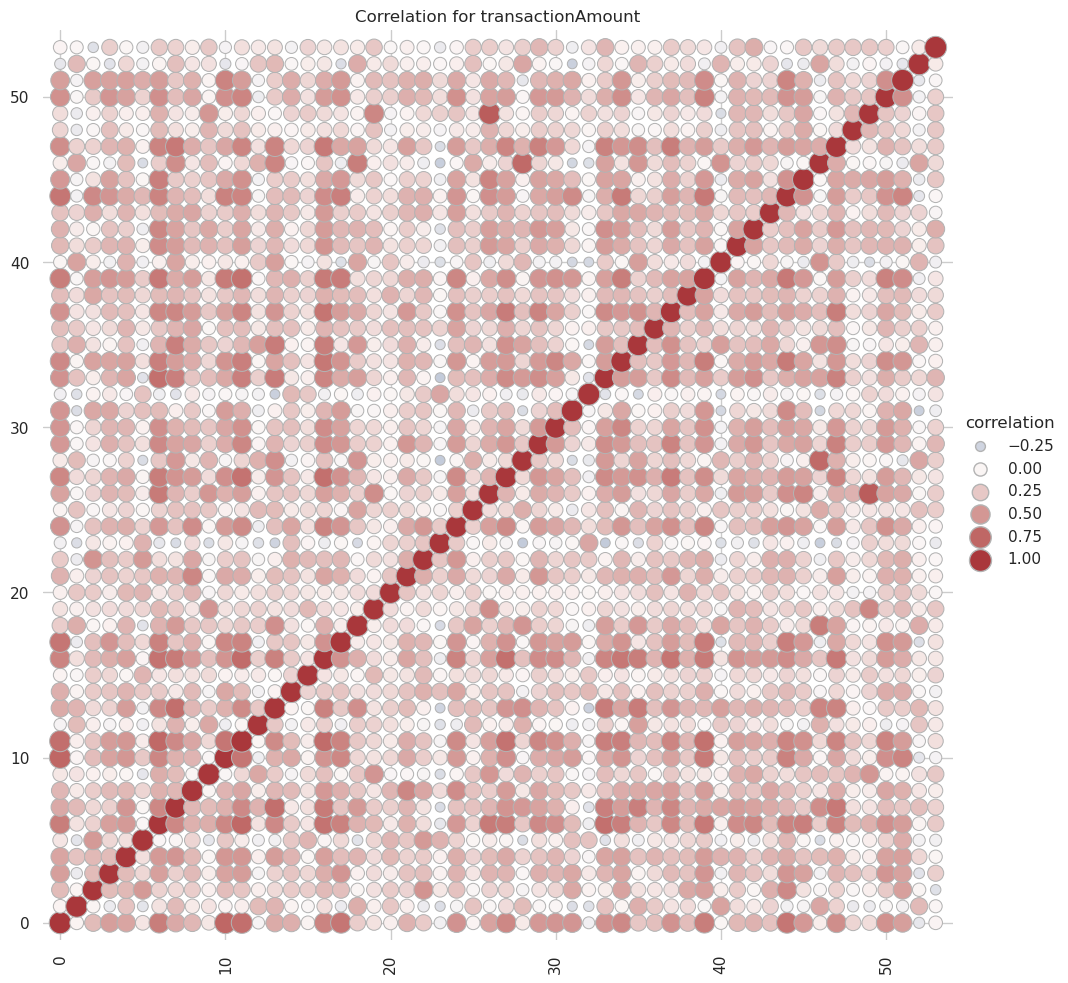

In [103]:
plot_corr(ds, 'transactionAmount')

How does transaction Amount correlate with return then?

It does not reveal much information either - but volatility seems to correlate with transaction

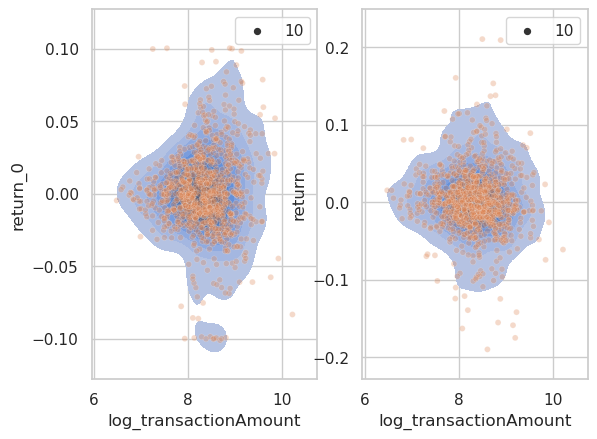

In [19]:
df = ds[['transactionAmount', 'return_0', 'return']].sel(asset=1).to_dataframe()
df[f'log_transactionAmount'] = np.log(df['transactionAmount'])
fig, axs = plt.subplots(nrows=1, ncols=2)
# return_label = 'return_0'
return_label = 'return'
for ax, return_label in zip(axs, ['return_0', 'return']):
    sns.kdeplot(data=df, x=f'log_transactionAmount', y=return_label, ax=ax, fill=True)
    sns.scatterplot(data=df, x=f'log_transactionAmount', y=return_label, ax=ax, alpha=0.3, size=10)

## PE and PE_TTM

<Axes: xlabel='asset', ylabel='pe_ttm'>

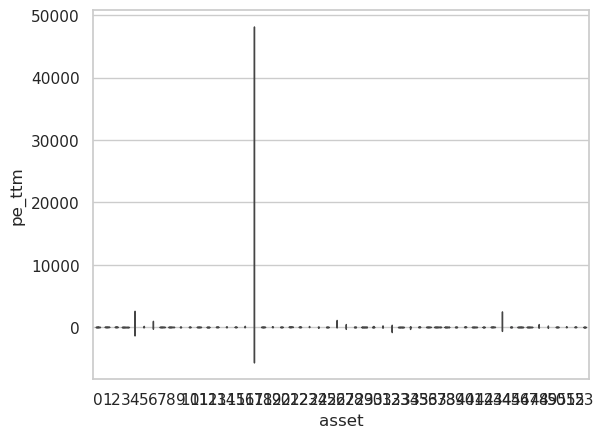

In [21]:
sns.violinplot(data=ds['pe_ttm'].to_dataframe().reset_index(), x='asset', y='pe_ttm', inner='quart', linewidth=1)

The asset=17 has very abnormal pe/pe_ttm, fishy

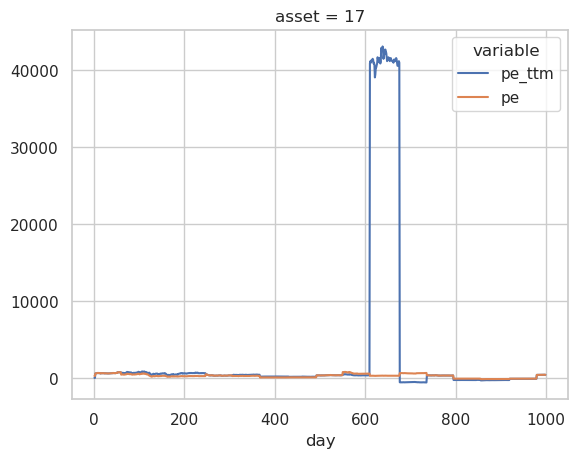

In [23]:
ds[['pe_ttm', 'pe']].sel(asset=17).to_array().plot.line(x='day')

That really scares me off. So what happends to the data? What is pe and pe_ttm?

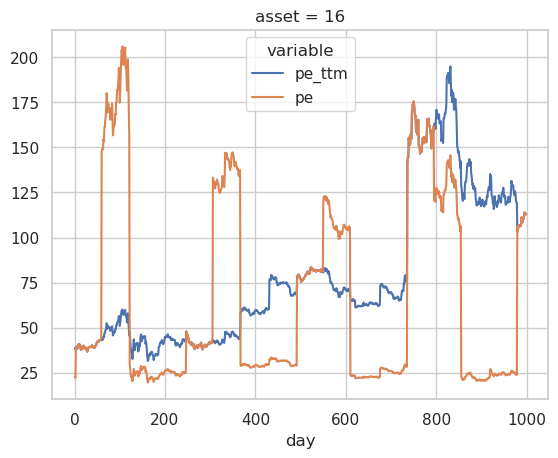

In [24]:
ds[['pe_ttm', 'pe']].sel(asset=16).to_array().plot.line(x='day')

okay, so if pe = price/earnings, then we should be able to revert earnings from price/pe

In [9]:
ds['earnings'] = ds['close'].sel(timeslot=50) / ds['pe']

In [10]:
ds['earnings']

<xarray.DataArray 'earnings' (day: 998, asset: 54)>
array([[0.75489198, 0.59148743, 0.21538641, ..., 0.14429001, 0.18540647,
        0.59384701],
       [0.75508643, 0.59210588, 0.2155157 , ..., 0.14447083, 0.1851741 ,
        0.59379922],
       [1.01458397, 0.54462157, 0.2315508 , ..., 0.09306383, 0.16545369,
        0.42031796],
       ...,
       [0.19452056, 0.91376268, 0.65018761, ..., 0.25502941, 0.99586142,
        0.93305344],
       [0.19457458, 0.9137026 , 0.65027559, ..., 0.25494147, 0.99581135,
        0.93296704],
       [0.19453525, 0.9136473 , 0.65012029, ..., 0.25453324, 0.99558502,
        0.9333133 ]])
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 991 992 993 994 995 996 997 998
  * asset    (asset) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53

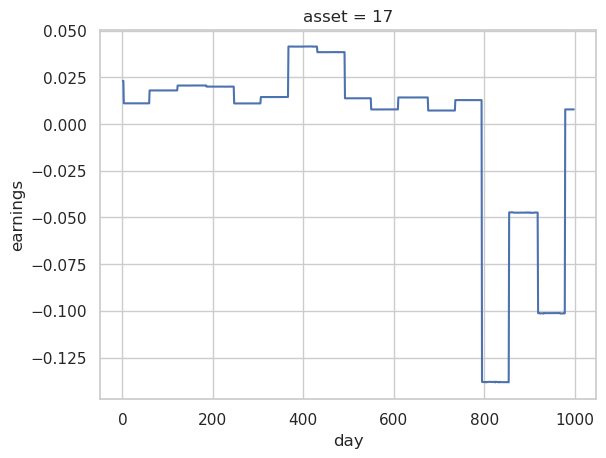

In [11]:
ds['earnings'].sel(asset=17).plot.line(x='day')

In [12]:
ds['earnings_ttm'] = ds['close'].sel(timeslot=50) / ds['pe_ttm']

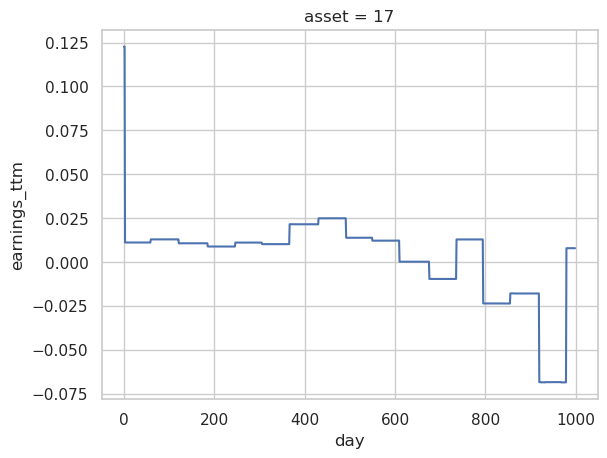

In [13]:
ds['earnings_ttm'].sel(asset=17).plot.line(x='day')

In [14]:
ds['my_earnings_ttm'] = ds['earnings'].rolling(day=250).mean()

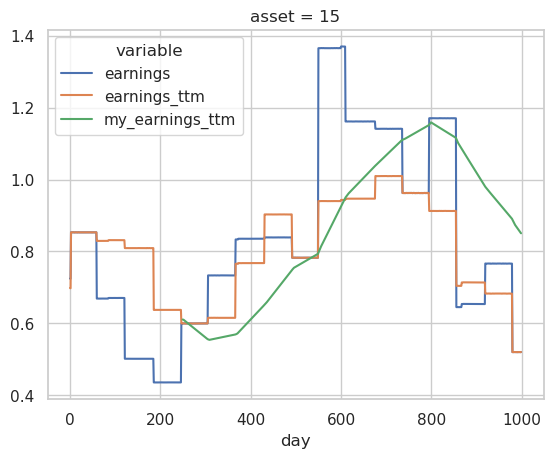

In [15]:
ds[['earnings', 'earnings_ttm', 'my_earnings_ttm']].sel(asset=15).to_array().plot.line(x='day')

TODO: how is earnings_ttm calculated? why there is always a segment that earnings and earnings_ttm agrees but not the remaining three?

ok, so does earnings provide a good hint of the return? let us overlay the close price with the earnings graph

In [16]:
ds['daily_close'] = ds['close'].sel(timeslot=50)

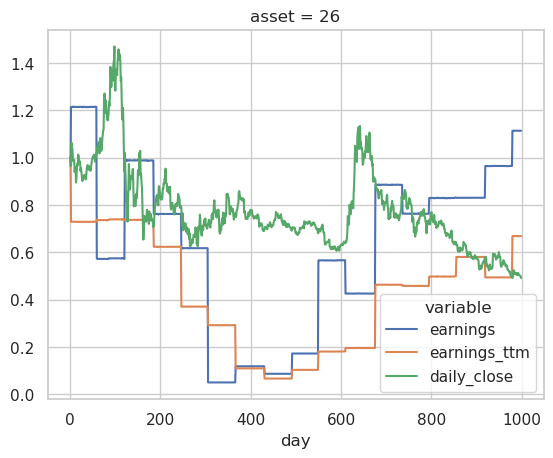

In [17]:
sub_ds = ds[['earnings', 'earnings_ttm', 'daily_close']].sel(asset=26)
(sub_ds / sub_ds.sel(day=1)).to_array().plot.line(x='day')

In [18]:
__ds = ds.sel(asset=26)['earnings']

In [19]:
earnings_jump = (__ds - __ds.shift(day=1)).fillna(0)

In [20]:
ej = earnings_jump.where(np.abs(earnings_jump) > 1e-3, 0)

In [27]:
ej_1_exp = ej.rolling_exp(day=1, window_type='halflife').mean()

In [22]:
ej_5_exp = ej.rolling_exp(day=5, window_type='halflife').mean()

<xarray.DataArray ()>
array(-0.0007322)
Coordinates:
    asset    int64 26

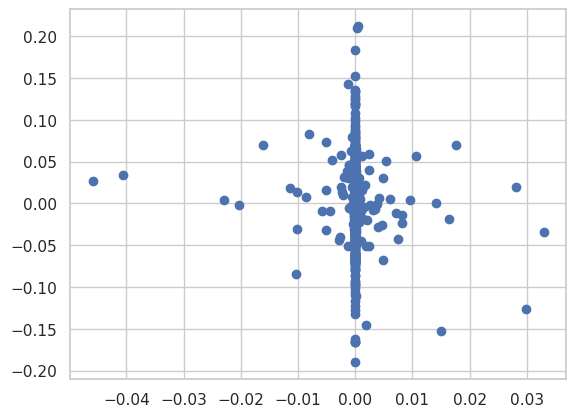

In [30]:
plt.scatter(ej_1_exp, ds.sel(asset=26)['return'])
xr.corr(ej_1_exp, ds.sel(asset=26)['return_0'])

In [25]:
from sklearn_xarray import wrap

class EarningsBasedModel:
    def __init__(self, exp_halflife = 20, per_eval_lookback = 60, pe_col = 'pe'):
        self.reg = LinearRegression()
        self.exp_halflife = exp_halflife
        self.per_eval_lookback = per_eval_lookback
        self.pe_col = pe_col
    
    def extract_ej(self, X):
        earnings = X[self.pe_col]
        earnings_jump = (earnings - earnings.shift(day=1)).fillna(0)
        ej_clean = earnings_jump.where(np.abs(earnings_jump) > 1e-3, 0)
        ej_exp = ej_clean.rolling_exp(day=exp_halflife).mean().isel(day=slice(self.per_eval_lookback-1,None))
        return ej_exp
    
    def fit_predict(self, X, y):
        ej_exp_df = self.extract_ej(X).to_dataset(name='ej_exp').to_dataframe()
        weight = np.abs(ej_exp_df.values[:, 0])
        # weight = 1
        # print(ej_exp_df)
        # print(y.to_series())
        self.reg.fit(ej_exp_df.values, y.to_series(), weight)
        pred = self.reg.predict(ej_exp_df.values)
        # print(self.reg.score(ej_exp_df.values, y.to_series()))
        return xr.DataArray.from_series(Series(pred, index=ej_exp_df.index))
    
    def predict(self, X):
        ej_exp_df = self.extract_ej(X).to_dataset(name='ej_exp').to_dataframe()
        pred = self.reg.predict(ej_exp_df.values)
        return xr.DataArray.from_series(Series(pred, index=ej_exp_df.index))

In [26]:
exp_halflife = 30
per_eval_lookback = 60
pe_col = 'pe_ttm'
model = EarningsBasedModel(exp_halflife = exp_halflife, per_eval_lookback = per_eval_lookback, pe_col = pe_col)
# ds[f'ej_ttm_{exp_day}_exp'] = ej_ttm_clean.rolling_exp(day=exp_day, window_type='halflife').mean()
feature = ['close_0', pe_col]
performance, cum_y_df = cross_validation(model, feature, 
                                         ds.sel(day=slice(200,998))[feature + ['return']],
                                         train_lookback=400, per_eval_lookback=per_eval_lookback)

  0%|          | 0/339 [00:00<?, ?it/s]

The ending score for metric train_r2 is: -9.3679e-05
The ending score for metric val_cum_r2 is: 4.6205e-04
The ending score for metric val_cum_pearson is: 2.8671e-02


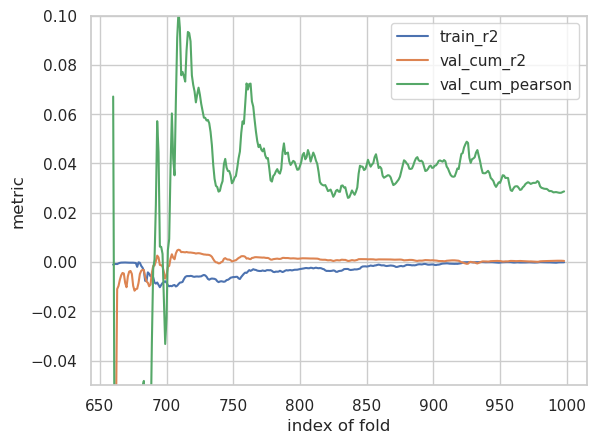

In [27]:
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

In [31]:
model = EarningsBasedModel(exp_halflife=60, per_eval_lookback=120, pe_col='pe_ttm')
performance = evaluation_for_submission(model, ds, qids, lookback_window=400, per_eval_lookback=model.per_eval_lookback)

  0%|          | 0/700 [00:00<?, ?it/s]

Data Feeding is finished.


The ending score for metric train_r2 is: -4.2999e-03
The ending score for metric test_cum_r2 is: -4.2497e-03
The ending score for metric test_cum_pearson is: -3.3181e-03


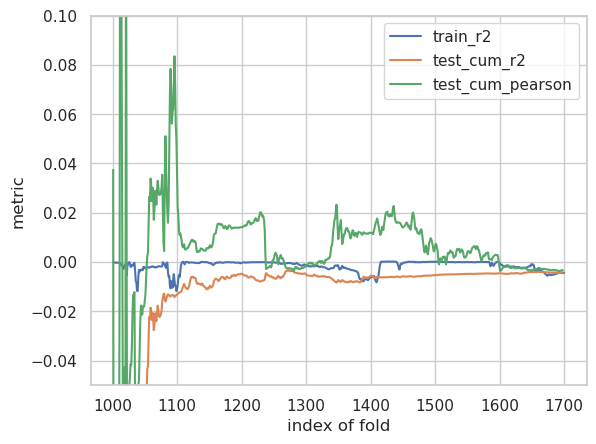

In [30]:
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])

anyways, that was some fun exercise

## PB

<Axes: xlabel='asset', ylabel='pb'>

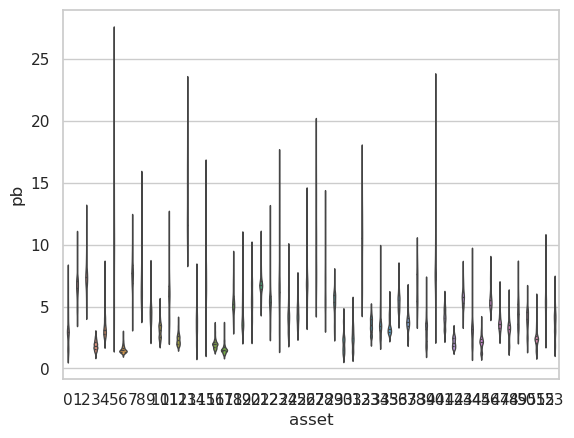

In [32]:
sns.violinplot(data=ds['pb'].to_dataframe().reset_index(), x='asset', y='pb', inner='quart', linewidth=1)

emmm, the pb value seems to vary a lot across assets

In [48]:
ds['book'] = ds['close_0'] / ds['pb']
ds['book_inc'] = ds['book'] - ds['book'].sel(day=1)

In [43]:
ds['earnings'] = ds['close_0'] / ds['pe']
ds['earnings_ttm'] = ds['close_0'] / ds['pe_ttm']

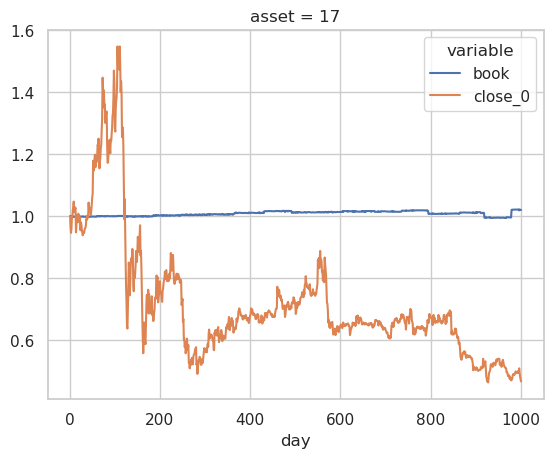

In [40]:
sub_ds = ds[['book', 'close_0']].sel(asset=17)
(sub_ds / sub_ds.sel(day=1)).to_array().plot.line(x='day')

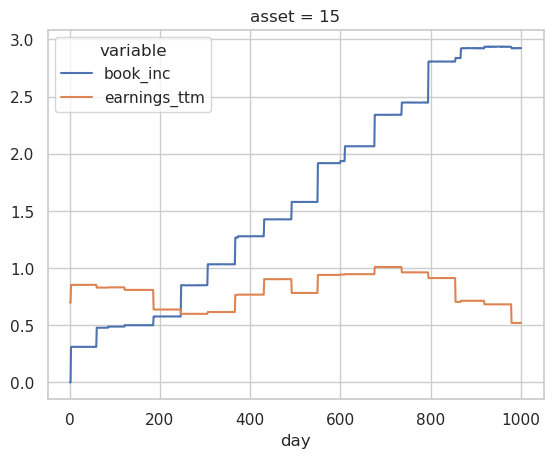

In [51]:
sub_ds = ds[['book_inc', 'earnings_ttm']].sel(asset=15)
sub_ds.to_array().plot.line(x='day')

conjecture: earnings is the derivative to book value

In [90]:
class BookBasedModel:
    def __init__(self, exp_halflife = 20, per_eval_lookback = 60):
        self.reg = LinearRegression()
        self.exp_halflife = exp_halflife
        self.per_eval_lookback = per_eval_lookback
    
    def extract_bj(self, X):
        book = X['close_0'] / X['pb']
        book_jump = book.diff('day', n=1)
        bj_clean = book_jump.where(np.abs(book_jump) > 1e-3, 0)
        relative_bj_clean = bj_clean / book
        ds = xr.Dataset({'bj_clean': bj_clean, 'relative_bj_clean': relative_bj_clean})
        # print('================')
        # print(ds)
        # print(ds.rolling_exp(day=exp_halflife).mean())
        # TODO: why day information is lost in rolling_exp?
        ds_exp = ds.rolling_exp(day=exp_halflife).mean().isel(day=slice(self.per_eval_lookback-2,None))
        return ds_exp
    
    def fit_predict(self, X, y):
        ds_exp_df = self.extract_bj(X).to_dataframe()
        weight = np.sqrt(np.abs(ds_exp_df.values[:, 0])+1e-3)
        # weight = 1
        # print(ej_exp_df)
        # print(y.to_series())
        self.reg.fit(ds_exp_df.values, y.to_series(), weight)
        pred = self.reg.predict(ds_exp_df.values)
        # print(self.reg.score(ej_exp_df.values, y.to_series()))
        return xr.DataArray.from_series(Series(pred, index=ds_exp_df.index))
    
    def predict(self, X):
        # print(X)
        ds_exp_df = self.extract_bj(X).to_dataframe()
        # print(ds_exp_df)
        pred = self.reg.predict(ds_exp_df.values)
        return xr.DataArray.from_series(Series(pred, index=ds_exp_df.index))

In [81]:
exp_halflife = 10
per_eval_lookback = 60
model = BookBasedModel(exp_halflife = exp_halflife, per_eval_lookback = per_eval_lookback)
feature = ['close_0', 'pb']
performance, cum_y_df = cross_validation(model, feature, 
                                         ds.sel(day=slice(200,998))[feature + ['return']],
                                         train_lookback=300, per_eval_lookback=per_eval_lookback)

  0%|          | 0/439 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:            (day: 358, asset: 54)
Coordinates:
  * day                (day) int32 201 202 203 204 205 ... 554 555 556 557 558
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.0 0.006121 ... -0.001501 0.001076
    relative_bj_clean  (day, asset) float64 0.0 0.001687 ... -0.00038 0.000331
<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 501 502 503 504 505 506 507 ... 555 556 557 558 559 560
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 502 503 504 505 506 ... 556 557 558 559 560
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean          

<xarray.Dataset>
Dimensions:            (day: 358, asset: 54)
Coordinates:
  * day                (day) int32 206 207 208 209 210 ... 559 560 561 562 563
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.0 0.00378 ... -0.005018 -0.001246
    relative_bj_clean  (day, asset) float64 0.0 0.00104 ... -0.00127 -0.0003833
<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 506 507 508 509 510 511 512 ... 560 561 562 563 564 565
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 507 508 509 510 511 ... 561 562 563 564 565
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean         

<xarray.Dataset>
Dimensions:            (day: 358, asset: 54)
Coordinates:
  * day                (day) int32 211 212 213 214 215 ... 564 565 566 567 568
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.0 0.002024 0.0 ... 0.0 0.0
    relative_bj_clean  (day, asset) float64 0.0 0.000557 0.0 ... 0.0 0.0
<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 511 512 513 514 515 516 517 ... 565 566 567 568 569 570
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 512 513 514 515 516 ... 566 567 568 569 570
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset)

<xarray.Dataset>
Dimensions:            (day: 358, asset: 54)
Coordinates:
  * day                (day) int32 216 217 218 219 220 ... 569 570 571 572 573
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.0 0.002406 ... -0.002207 0.002084
    relative_bj_clean  (day, asset) float64 0.0 0.0006618 ... 0.0006409
<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 516 517 518 519 520 521 522 ... 570 571 572 573 574 575
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 517 518 519 520 521 ... 571 572 573 574 575
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, 

<xarray.Dataset>
Dimensions:            (day: 358, asset: 54)
Coordinates:
  * day                (day) int32 221 222 223 224 225 ... 574 575 576 577 578
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.0 0.0 0.0 ... 0.003051 0.0
    relative_bj_clean  (day, asset) float64 0.0 0.0 0.0 ... 0.0007615 0.0
<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 521 522 523 524 525 526 527 ... 575 576 577 578 579 580
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 522 523 524 525 526 ... 576 577 578 579 580
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset

<xarray.Dataset>
Dimensions:            (day: 358, asset: 54)
Coordinates:
  * day                (day) int32 226 227 228 229 230 ... 579 580 581 582 583
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.0 0.0 ... 0.001387 0.002128
    relative_bj_clean  (day, asset) float64 0.0 0.0 ... 0.0003466 0.0006545
<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 526 527 528 529 530 531 532 ... 580 581 582 583 584 585
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 527 528 529 530 531 ... 581 582 583 584 585
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, as

<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 530 531 532 533 534 535 536 ... 584 585 586 587 588 589
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 531 532 533 534 535 ... 585 586 587 588 589
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 -0.001615 0.0 0.0 ... 0.008685 0.0
    relative_bj_clean  (day, asset) float64 -0.0002367 0.0 0.0 ... 0.002166 0.0
           bj_clean  relative_bj_clean
asset day                             
0     0    0.000239           0.000035
1     0    0.003377           0.000730
2     0    0.000262           0.000090
3     0   -0.000639          -0.000112
4     0    0.001413           0.000803


               bj_clean  relative_bj_clean
asset day                                 
0     0   -9.465068e-05      -1.379886e-05
1     0    1.243790e-03       2.686490e-04
2     0    1.158505e-04       3.967502e-05
3     0   -9.802373e-05      -1.742637e-05
4     0    3.673880e-04       2.082246e-04
5     0    3.663420e-05       1.712330e-05
6     0   -1.916498e-03      -8.825921e-04
7     0    8.047230e-04       1.610288e-04
8     0    2.815893e-05       1.687229e-05
9     0    9.446460e-06       8.727113e-06
10    0    2.173698e-03       4.022113e-04
11    0    4.982766e-04       1.157768e-04
12    0    3.891016e-07      -3.822624e-08
13    0    8.495246e-05       3.658538e-05
14    0   -1.906703e-04      -5.437974e-05
15    0    1.048382e-05       1.940284e-06
16    0    2.037149e-04       4.532211e-05
17    0    1.014155e-04       3.033869e-05
18    0   -4.522340e-05      -4.053388e-06
19    0    1.506936e-03       5.995290e-04
20    0    7.595859e-04       3.479705e-04
21    0    

<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 539 540 541 542 543 544 545 ... 593 594 595 596 597 598
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 540 541 542 543 544 ... 594 595 596 597 598
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.0 0.0 0.0 ... 0.0 0.001787
    relative_bj_clean  (day, asset) float64 0.0 0.0 0.0 ... 0.0 0.0005497
           bj_clean  relative_bj_clean
asset day                             
0     0    0.000383       5.567026e-05
1     0   -0.000189      -4.336940e-05
2     0    0.000199       6.834922e-05
3     0   -0.001908      -3.340148e-04
4     0    0.000528       2.993680e-04
5     0    0

<xarray.Dataset>
Dimensions:            (day: 358, asset: 54)
Coordinates:
  * day                (day) int32 244 245 246 247 248 ... 597 598 599 600 601
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.0 -0.002496 ... -0.02396 -0.00187
    relative_bj_clean  (day, asset) float64 0.0 -0.0006871 ... -0.0005753
<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 544 545 546 547 548 549 550 ... 598 599 600 601 602 603
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 545 546 547 548 549 ... 599 600 601 602 603
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day

<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 549 550 551 552 553 ... 603 604 605 606 607
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.001837 0.0 ... 0.006965 0.0
    relative_bj_clean  (day, asset) float64 0.0002692 0.0 ... 0.00174 0.0
               bj_clean  relative_bj_clean
asset day                                 
0     0   -3.079277e-04      -4.487705e-05
1     0   -8.995438e-04      -1.955471e-04
2     0    3.279331e-05       1.123650e-05
3     0    1.032434e-02       1.755632e-03
4     0    1.810972e-04       1.023923e-04
5     0    2.437031e-04       1.138903e-04
6     0   -3.313384e-04      -1.557617e-04
7     0    1.191249e-04       2.382712e-05
8     0    1.347877e-03       7.778659e-04
9     0    8.238362e-04       9.124732e-04
10    0   -1.838339e-04      -3.407863e-05
11    0   -1.355407e-04      -3.151880e-05


<xarray.Dataset>
Dimensions:            (day: 358, asset: 54)
Coordinates:
  * day                (day) int32 253 254 255 256 257 ... 606 607 608 609 610
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 -0.001383 -0.003881 ... 0.006224
    relative_bj_clean  (day, asset) float64 -0.0002291 -0.001042 ... 0.001911
<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 553 554 555 556 557 558 559 ... 607 608 609 610 611 612
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 554 555 556 557 558 ... 608 609 610 611 612
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (da

<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 557 558 559 560 561 562 563 ... 611 612 613 614 615 616
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 558 559 560 561 562 ... 612 613 614 615 616
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.001278 -0.02777 ... -0.004177 0.0
    relative_bj_clean  (day, asset) float64 0.000186 -0.006076 ... -0.001062 0.0
           bj_clean  relative_bj_clean
asset day                             
0     0    0.005352           0.000774
1     0    0.008674           0.001816
2     0    0.007717           0.002523
3     0   -0.002070          -0.000363
4     0   -0.000486          -0.00027

           bj_clean  relative_bj_clean
asset day                             
0     0    0.002123           0.000307
1     0    0.003559           0.000745
2     0    0.003569           0.001167
3     0   -0.002418          -0.000420
4     0   -0.000927          -0.000531
5     0    0.000106           0.000049
6     0    0.001304           0.000570
7     0   -0.008074          -0.001731
8     0   -0.006928          -0.004801
9     0    0.000324           0.000350
10    0    0.001712           0.000313
11    0   -0.002506          -0.000596
12    0    0.000291           0.000100
13    0   -0.005413          -0.002633
14    0    0.000165           0.000047
15    0    0.003105           0.000559
16    0    0.005752           0.001239
17    0    0.000253           0.000076
18    0   -0.004630          -0.000428
19    0    0.000791           0.000311
20    0    0.003981           0.001715
21    0   -0.000769          -0.000131
22    0    0.001037           0.000230
23    0    0.000661      

<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 566 567 568 569 570 571 572 ... 620 621 622 623 624 625
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 567 568 569 570 571 ... 621 622 623 624 625
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.0 0.004007 ... 0.008156 0.0
    relative_bj_clean  (day, asset) float64 0.0 0.0008728 ... 0.002069 0.0
           bj_clean  relative_bj_clean
asset day                             
0     0    0.001020           0.000148
1     0    0.002188           0.000456
2     0    0.001290           0.000422
3     0   -0.001520          -0.000264
4     0   -0.000306          -0.000175
5     0   

<xarray.Dataset>
Dimensions:            (day: 358, asset: 54)
Coordinates:
  * day                (day) int32 271 272 273 274 275 ... 624 625 626 627 628
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 -0.001049 0.0 0.0 ... 0.002214 0.0
    relative_bj_clean  (day, asset) float64 -0.0001738 0.0 0.0 ... 0.0005628 0.0
<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 571 572 573 574 575 576 577 ... 625 626 627 628 629 630
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 572 573 574 575 576 ... 626 627 628 629 630
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean         

<xarray.Dataset>
Dimensions:            (day: 358, asset: 54)
Coordinates:
  * day                (day) int32 276 277 278 279 280 ... 629 630 631 632 633
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean           (day, asset) float64 0.001548 0.0 0.0 ... -0.001534 0.0
    relative_bj_clean  (day, asset) float64 0.0002563 0.0 0.0 ... -0.0003899 0.0
<xarray.Dataset>
Dimensions:  (day: 60, asset: 54)
Coordinates:
  * day      (day) int32 576 577 578 579 580 581 582 ... 630 631 632 633 634 635
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53
Data variables:
    close_0  (day, asset) float64 ...
    pb       (day, asset) float64 ...
<xarray.Dataset>
Dimensions:            (day: 59, asset: 54)
Coordinates:
  * day                (day) int32 577 578 579 580 581 ... 631 632 633 634 635
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
Data variables:
    bj_clean         

KeyboardInterrupt: 

In [ ]:
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

In [91]:
model = BookBasedModel(exp_halflife = exp_halflife, per_eval_lookback = per_eval_lookback)
performance = evaluation_for_submission(model, ds_bak, qids, lookback_window=400, per_eval_lookback=model.per_eval_lookback)

  0%|          | 0/700 [00:00<?, ?it/s]

Data Feeding is finished.


The ending score for metric train_r2 is: 2.5182e-04
The ending score for metric test_cum_r2 is: -2.4534e-03
The ending score for metric test_cum_pearson is: -4.4246e-03


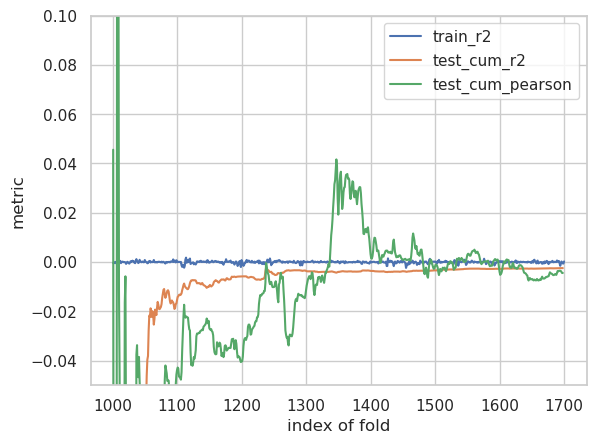

In [92]:
plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])

nvm, not working again

can we cluster asset by their book value/earnings?

/tmp/ipykernel_149554/2636301194.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for artist in g.legend.legendHandles:


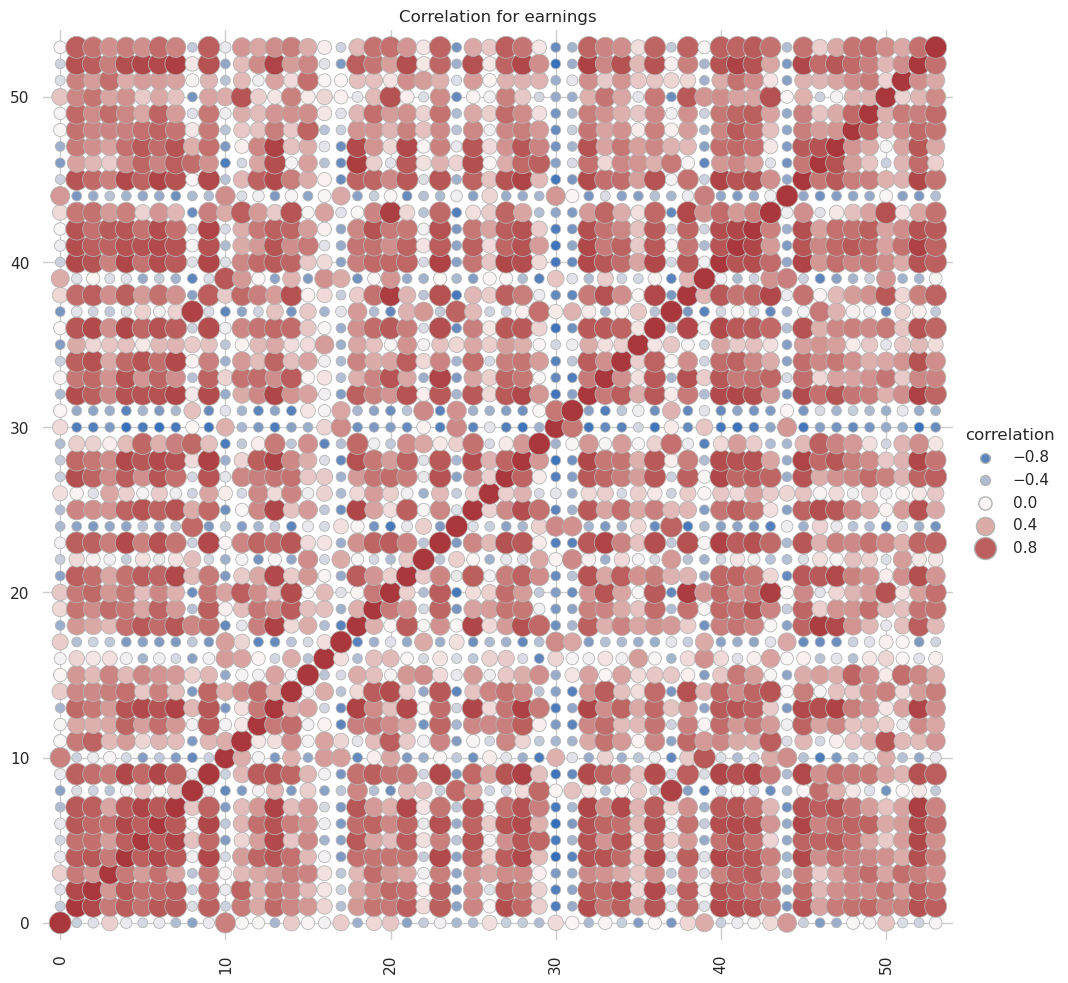

In [104]:
plot_corr(ds, 'earnings')

/tmp/ipykernel_149554/2636301194.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for artist in g.legend.legendHandles:


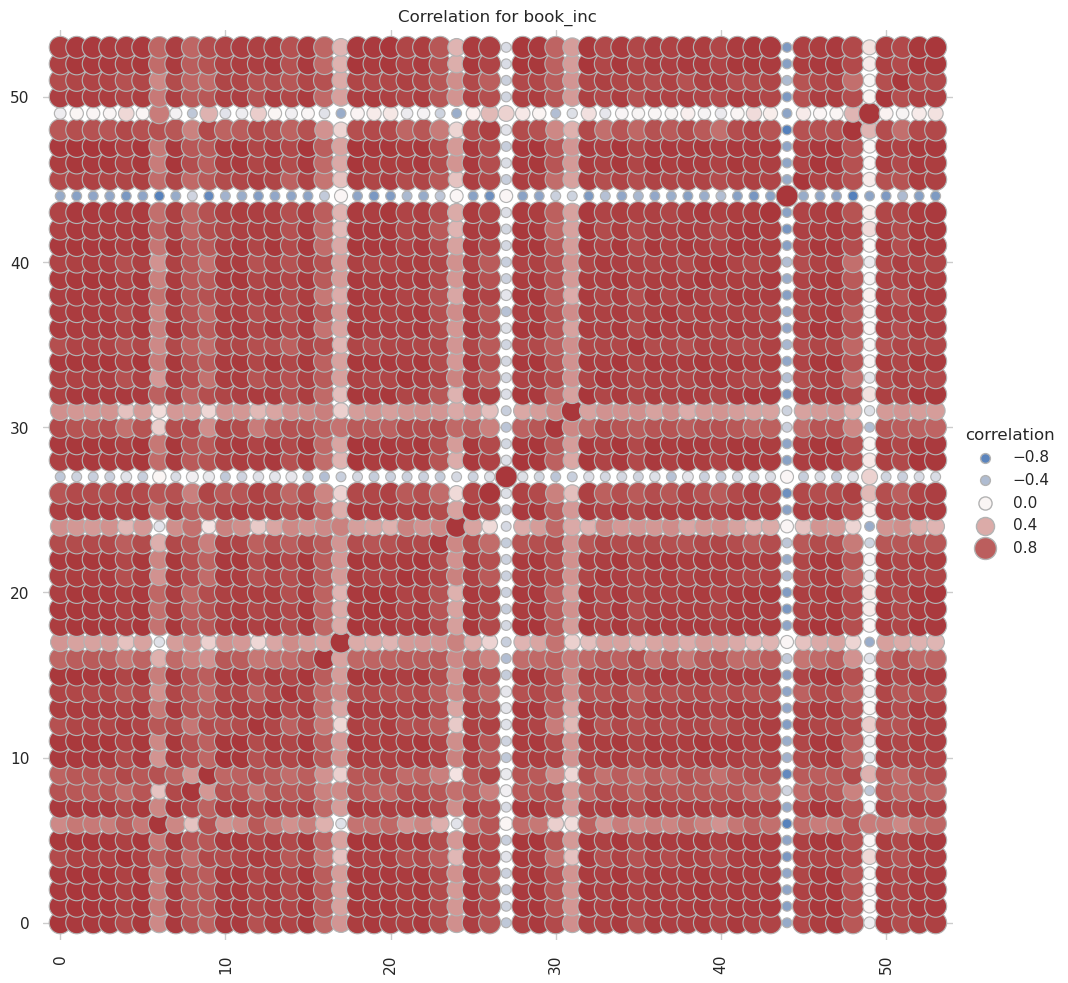

In [106]:
plot_corr(ds, 'book_inc')

hmm, interesting! so most assets have growing book values, while so "outliers" may exhibit different behaviors

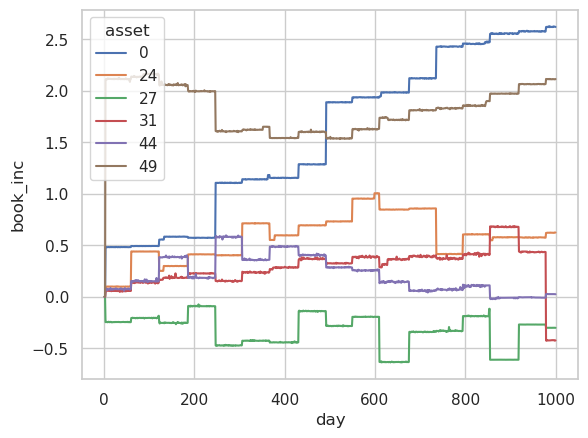

In [108]:
ds['book_inc'].sel(asset=[0, 24, 27, 31, 44, 49]).plot.line(x='day')

## PS

<Axes: xlabel='asset', ylabel='ps'>

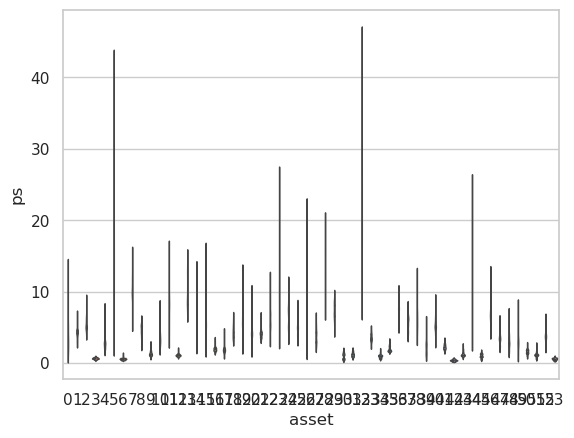

In [111]:
sns.violinplot(data=ds['ps'].to_dataframe().reset_index(), x='asset', y='ps', inner='quart', linewidth=1)

In [126]:
ds['sales'] = ds['close_0'] / ds['ps']
ds['sales_to_earnings'] = ds['sales'] / ds['earnings']
ds['sales_to_book'] = ds['sales'] / ds['book']

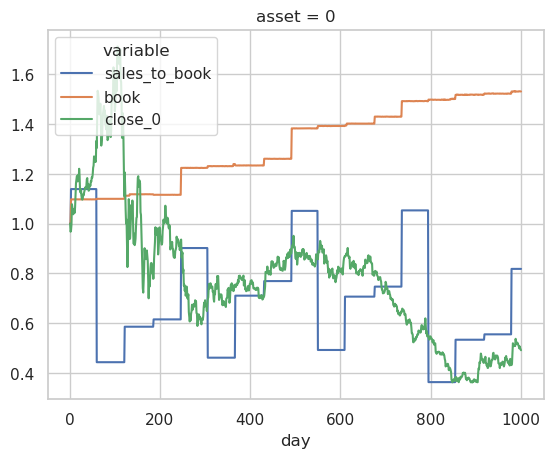

In [128]:
sub_ds = ds[['sales_to_book', 'book', 'close_0']].sel(asset=0)
(sub_ds / sub_ds.sel(day=1)).to_array().plot.line(x='day')

not much to say, but definitely sales correlates with earnings

## PCF

<Axes: xlabel='asset', ylabel='pcf'>

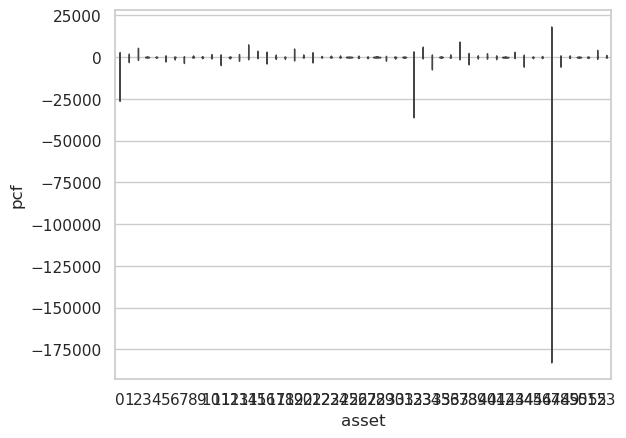

In [130]:
sns.violinplot(data=ds['pcf'].to_dataframe().reset_index(), x='asset', y='pcf', inner='quart', linewidth=1)

wow, very spicy!

In [132]:
ds['cf'] = ds['close_0'] / ds['pcf']

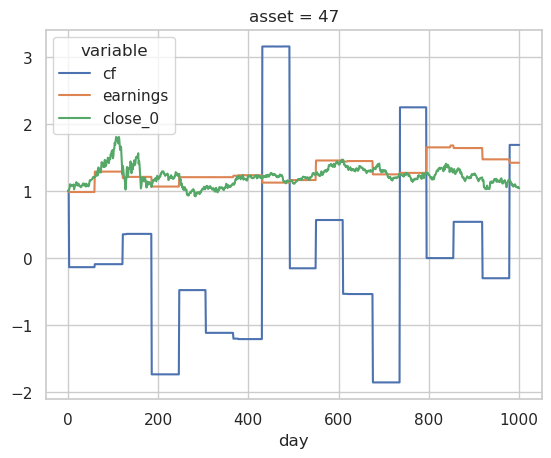

In [134]:
sub_ds = ds[['cf', 'earnings', 'close_0']].sel(asset=47)
(sub_ds / sub_ds.sel(day=1)).to_array().plot.line(x='day')

## End